In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import logomaker

In [2]:
style_file_name = 'fig6.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

#### Load data and define helper functions required to plot GB1 heatmaps

In [5]:
gb1_seq = 'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
alphabet = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P','Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

theta_folding_lc_gf = np.load('../old/GB1_emats/neg_theta_folding_gf_kcal.npy')
theta_binding_lc_gf = np.load('../old/GB1_emats/neg_theta_binding_gf_kcal.npy')

In [6]:
# Function to draw heatmap
from matplotlib.colors import TwoSlopeNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(values,
            alphabet,
            seq=None,
            seq_kwargs=None,
            ax=None,
            show_spines=False,
            cbar=True,
            cax=None,
            clim=None,
            clim_quantile=1,
            ccenter=None,
            cmap='coolwarm',
            cmap_size="5%",
            cmap_pad=0.1,
            first_pos=1):
    """
    Draw a heatmap illustrating an ``L`` x ``C`` matrix of values, where ``L`` is
    sequence length and ``C`` is the alphabet size.

    Parameters
    ----------
    values: (np.ndarray)
        Array of shape ``(L,C)`` that contains values to plot.

    alphabet: (str, np.ndarray)
        Alphabet name ``'dna'``, ``'rna'``, or ``'protein'``, or 1D array
        containing characters in the alphabet.

    seq: (str, None)
        The sequence to show, if any, using dots plotted on top of the heatmap.
        Must have length ``L`` and be comprised of characters in ``alphabet``.

    seq_kwargs: (dict)
        Arguments to pass to ``Axes.scatter()`` when drawing dots to illustrate
        the characters in ``seq``.

    ax: (matplotlib.axes.Axes)
        The ``Axes`` object on which the heatmap will be drawn.
        If ``None``, one will be created. If specified, ``cbar=True``,
        and ``cax=None``, ``ax`` will be split in two to make room for a
        colorbar.

    show_spines: (bool)
        Whether to show spines around the edges of the heatmap.

    cbar: (bool)
        Whether to draw a colorbar next to the heatmap.

    cax: (matplotlib.axes.Axes, None)
        The ``Axes`` object on which the colorbar will be drawn,
        if requested. If ``None``, one will be created by splitting
        ``ax`` in two according to ``cmap_size`` and ``cmap_pad``.

    clim: (list, None)
        List of the form ``[cmin, cmax]``, specifying the maximum ``cmax``
        and minimum ``cmin`` values spanned by the colormap. Overrides
        ``clim_quantile``.

    clim_quantile: (float)
        Must be a float in the range [0,1]. ``clim`` will be automatically
        chosen to include this central quantile of values.

    ccenter: (float)
        Value at which to position the center of a diverging
        colormap. Setting ``ccenter=0`` often makes sense.

    cmap: (str, matplotlib.colors.Colormap)
        Colormap to use.

    cmap_size: (str)
        Fraction of ``ax`` width to be used for the colorbar. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.

    cmap_pad: (float)
        Space between colorbar and the shrunken heatmap ``Axes``. For formatting
        requirements, see the documentation for
        ``mpl_toolkits.axes_grid1.make_axes_locatable()``.
        
    first_pos: (int)
        Value of first position. 

    Returns
    -------
    ax: (matplotlib.axes.Axes)
        ``Axes`` object containing the heatmap.

    cb: (matplotlib.colorbar.Colorbar, None)
        Colorbar object linked to ``ax``, or ``None`` if no colorbar was drawn.
    """
    #alphabet = validate_alphabet(alphabet)
    L, C = values.shape

    # Set extent
    #xlim = [-.5, L - .5]
    xlim = [first_pos - .5, L + first_pos - .5]
    ylim = [-.5, C - .5]

    # If wt_seq is set, validate it.
    #if seq:
    #    seq = validate_seqs(seq, alphabet)

    # Set color lims to central 95% quantile
    if clim is None:
        vals = values.ravel()
        vals = vals[np.isfinite(vals)]
        clim = np.quantile(vals, q=[(1 - clim_quantile) / 2,
                                    1 - (1 - clim_quantile) / 2])

    # Create axis if none already exists
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Needed to center colormap at zero
    if ccenter is not None:

        # Reset ccenter if is not compatible with clim
        if (clim[0] > ccenter) or (clim[1] < ccenter):
            ccenter = 0.5 * (clim[0] + clim[1])

        norm = TwoSlopeNorm(vmin=clim[0], vcenter=ccenter, vmax=clim[1])

    # Otherwise, use uncentered colormap
    else:
        norm = Normalize(vmin=clim[0], vmax=clim[1])

    # Plot heatmap
    #x_edges = np.arange(L + 1) - .5
    x_edges = np.arange(L + 1) + first_pos - 0.5
    y_edges = np.arange(C + 1) - .5
    im = ax.pcolormesh(x_edges,
                       y_edges,
                       values.T,
                       shading='flat',
                       cmap=cmap,
                       clim=clim,
                       norm=norm)

    # Mark wt sequence
    _ = np.newaxis
    if seq:
        
        seq = [seq]
        # Set marker style
        if seq_kwargs is None:
            seq_kwargs = {'marker': '.', 'color': 'k', 's': 2}

        # Get xy coords to plot
        seq_arr = np.array(list(seq[0]))
        xy = np.argwhere(seq_arr[:, _] == alphabet[_, :])

        # Mark sequence
        ax.scatter(xy[:, 0] + first_pos, xy[:, 1], **seq_kwargs)
        #pdb.set_trace()

    # Style plot
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_yticks(range(C))
    ax.set_yticklabels(alphabet, ha='center')
    ax.invert_yaxis()

    if not show_spines:
        for loc, spine in ax.spines.items():
            spine.set_visible(False)

    # Create colorbar if requested, make one
    if cbar:
        if cax is None:
            cax = make_axes_locatable(ax).new_horizontal(size=cmap_size,
                                                         pad=cmap_pad)
            fig.add_axes(cax)
        cb = plt.colorbar(im, cax=cax)

        # Otherwise, return None for cb
    else:
        cb = None

    return ax, cb

# Draw panel b (GB1 energy matrices)

In [7]:
# Get indices for aa order used in Olson et al.
ordered_aa = np.array(list('EDRKHQNSTPGCAVILMFYW'))
ix = ordered_aa.argsort()
sorted_aa = ordered_aa[ix]
ixx = ix.argsort()
sorted_aa[ixx]

array(['E', 'D', 'R', 'K', 'H', 'Q', 'N', 'S', 'T', 'P', 'G', 'C', 'A',
       'V', 'I', 'L', 'M', 'F', 'Y', 'W'], dtype='<U1')

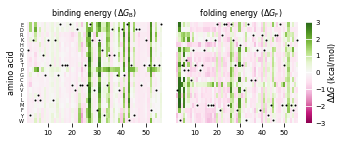

In [9]:
## heatmaps

# Create two panels
fig, axs = plt.subplots(1, 2, figsize=[4.8,2.0])
fontsize=8.0

# Left panel: draw heatmap illustrating 1pt mutation effects
ax = axs[0]
ax, cb = heatmap(-theta_binding_lc_gf[:,ixx],
                    alphabet=alphabet[ixx],
                    seq=gb1_seq,
                    clim=[-3,3],
                    cbar=False,
                    seq_kwargs={'s':1,'c':'black'},
                    cmap='PiYG',
                    ccenter=0,
                    ax=ax,
                    first_pos=2)
ax.tick_params(labelsize=5, rotation=0, axis='y', length=0, pad=5)
ax.tick_params(rotation=0, axis='x')
ax.set_xticks(range(10,60,10))

#ax.set_xlabel('position',fontsize=fontsize)
ax.set_ylabel('amino acid',fontsize=fontsize,labelpad=3)
#cb.set_label('-$\Delta\Delta G$', rotation=-90, va="bottom",fontsize=fontsize)
ax.set_title('binding energy ($\Delta G_\mathrm{B}$)',fontsize=fontsize)


ax = axs[1]
# Left panel: draw heatmap illustrating 1pt mutation effects
ax, cb1 = heatmap(-theta_folding_lc_gf,
                        alphabet=alphabet,
                        seq=gb1_seq,
                        clim=[-3,3],
                        cmap='PiYG',
                        seq_kwargs={'s':1,'c':'black'},                         
                        ccenter=0,
                        ax=ax,
                        first_pos=2)
#ax.set_xlabel('position',fontsize=fontsize)
#ax.set_ylabel('amino acid ($c$)',fontsize=fontsize)
cb1.set_label('$\Delta\Delta G$ (kcal/mol)', rotation=90, fontsize=fontsize, labelpad=0)
cb1.set_ticks([-3, -2, -1, 0, 1, 2, 3])
cb1.outline.set_visible(False)
cb1.ax.tick_params(direction='in', size=10, color='white')
ax.set_title('   folding energy ($\Delta G_\mathrm{F}$)',fontsize=fontsize)
ax.tick_params(labelsize=5, rotation=0, axis='y')
ax.set_yticks([])
ax.tick_params(rotation=0, axis='x')
ax.set_xticks(range(10,60,10))

#fig.subplots_adjust(left=3, bottom=1, right=5, top=2, wspace=5, hspace=None)
# Fix up plot
fig.tight_layout(h_pad=1,w_pad=2)
fig.savefig('png/panel_b.png', bbox_inches='tight', dpi=300, facecolor='white')
plt.show()

#### Load xylE data

In [10]:
style_file_name = 'fig6.style'
s = """
axes.linewidth:     0.5     # edge linewidth
font.size:          7.0
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      8.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
legend.framealpha:    1.0 
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [11]:
# Function to draw logos
def draw_logo(ax, df, ylim=[-1,1], highlight_color='#9981B3', highlight_alpha=0.1):
    xmin = int(df.index.min())
    xmax = int(df.index.max())
    xlim = [xmin-.5, xmax+.5]
    logo = logomaker.Logo(-0.62*df, ax=ax, center_values=True, font_name='Arial Rounded MT Bold')
    ax.set_ylim(ylim)
    ax.set_yticks([ylim[0], 0, ylim[1]])
    logo.style_xticks(anchor=0, spacing=10)
    logo.style_spines(visible=False)
    logo.highlight_position_range(xmin, xmax, alpha=highlight_alpha, color=highlight_color)  
    ax.set_ylabel('$-\Delta \Delta G$ (kcal/mol)', labelpad=-1)
    return logo


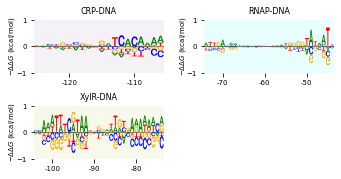

In [12]:
###
### Panel i
###

fig, axs = plt.subplots(2,2,figsize=[4.75,2.5])

# CRP logo
ax=axs[0,0]
xylE_crp_df = pd.read_csv('../old/xylE_emats/crp_df_x.csv',index_col=[0])
xylE_crp_logo = draw_logo(ax=ax, df=xylE_crp_df, highlight_color='#9981B3', highlight_alpha=0.1)
ax.set_title("CRP-DNA", fontsize=8)

# RNAP logo
ax=axs[0,1]
xylE_rnap_df = pd.read_csv('../old/xylE_emats/rnap_df_x.csv',index_col=[0])
xylE_rnap_logo = draw_logo(ax=ax, df=xylE_rnap_df, highlight_color='lightcyan', highlight_alpha=0.7)
ax.set_title("RNAP-DNA", fontsize=8)

# XylR logo
ax=axs[1,0]
xylE_xylR_df = pd.read_csv('../old/xylE_emats/xylR_df.csv',index_col=[0])
xylE_xylR_df = draw_logo(ax=ax, df=xylE_xylR_df, highlight_color='#b6cc34', highlight_alpha=0.1)
ax.set_title("XylR-DNA", fontsize=8)

# Adjust figure
axs[1,1].axis('off')
fig.tight_layout(w_pad=2, h_pad=1)

# Save and show figure
fig.savefig('png/panel_g.png',dpi=300, facecolor='white')
plt.show()

In [13]:
lac_crp_df = pd.read_csv('../old/lac_emats/crp_df_ss.csv',index_col=[0])
lac_crp_df.index = lac_crp_df.index - 74
print(len(lac_crp_df))
lac_crp_df

26


,A,C,G,T
-74,-0.025452,-0.418974,-0.424680,-0.163769
-73,0.149639,-0.626404,-0.410417,-0.152081
-72,0.084692,-0.672206,-0.483802,0.040955
-71,0.086436,-0.647273,-0.697609,0.235782
-70,-0.183843,-0.471936,-0.301144,-0.074583
-69,-0.588518,-0.160174,-0.774618,0.474204
-68,-0.622455,-0.769516,0.823621,-0.481826
-67,-0.263655,-0.533477,-0.642228,0.403680
-66,-0.676017,-0.898767,0.987678,-0.460553
-65,0.534701,-0.193370,-0.669382,-0.706789


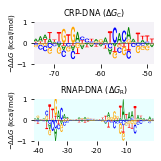

In [14]:
###
### Panel f
###

fig, axs = plt.subplots(2,1,figsize=[2.25,2.25])

# CRP logo
ax = axs[0]
lac_crp_df = pd.read_csv('../old/lac_emats/crp_df_ss.csv',index_col=[0])
lac_crp_df.index = lac_crp_df.index - 74
lac_crp_logo = draw_logo(ax=ax, df=-lac_crp_df, highlight_color='#9981B3', highlight_alpha=0.1)
ax.set_title("CRP-DNA ($\Delta G_\mathrm{C}$)", fontsize=8)

# RNAP logo
ax = axs[1]
lac_rnap_df = pd.read_csv('../old/lac_emats/rnap_df_ss.csv',index_col=[0])
lac_rnap_logo = draw_logo(ax=ax, df=-lac_rnap_df, highlight_color='lightcyan', highlight_alpha=0.7)
ax.set_title("RNAP-DNA ($\Delta G_\mathrm{R}$)", fontsize=8)

# Save and show figure
fig.tight_layout(h_pad=1)
fig.savefig('png/panel_e.png',dpi=300, facecolor='white')
plt.show()

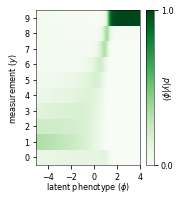

In [15]:
###
### Panel e
###

fig, ax = plt.subplots(figsize=(2.5,2.8))

# Define helper variables
phi_lim = [-5, 4]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = 10
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Load measurement process
measurement_process_ss = np.load('../old/lac_emats/measurement_process_ss.npy')

# Plot measurement process
tick_spacing=10
fontsize = 8
im = ax.imshow(measurement_process_ss,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               vmax=1.0,
               origin='lower',
               interpolation='nearest',)
ax.set_yticks(y_all)
ax.set_ylabel('measurement ($y$)',fontsize=fontsize)
ax.set_xlabel('latent phenotype ($\phi$)',fontsize=fontsize,labelpad=-1)
ax.set_xticks([-4, -2,  0, 2, 4])
cb = plt.colorbar(im, **{'format': '%0.1f','ticks': [0, 1],}, ax=ax)
cb.ax.tick_params(labelsize=7.5)
ax.set_aspect('auto')
cb.set_label('$p(y|\phi)$', rotation=-90, va="bottom", fontsize=fontsize, labelpad=-15)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(labelsize=fontsize)

fig.tight_layout()
fig.savefig('png/panel_d.png',dpi=300, facecolor='white')